In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
import optuna
from optuna.integration import LightGBMPruningCallback

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")

In [96]:
def preprocess(df):
  df.index = pd.to_datetime(df["datetime"])
  df = df["2014-05-01":]
  df = df.reset_index(drop=True)
  
  def weather(x):
    if x.find("快晴"):
      x = 0
    elif x.find("晴れ"):
      x = 1
    elif x.find("曇"):
      x = 2
    elif x.find("薄曇"):
      x = 3
    elif x.find("雨"):
      x = 4 
    else:
      x = 5
    return x

  df["days"] = df.index
  df["precipitation"] = df["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float64)
  df["fun"] = df["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
  df["curry"] = df["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
  df["weather"] = df["weather"].apply(weather)
  #df["subuta"] = df["name"].apply(lambda x : 1 if x.find("酢豚")>=0 else 0)
  #df["sp"] = df["remarks"].apply(lambda x : 1 if x==("スペシャルメニュー")>=0 else 0)
  #df["kd"] = df["remarks"].apply(lambda x : 1 if x==("料理長")>=0 else 0)
  
  categorical_cols = ["precipitation", "weather", "days", "fun", "curry", "week", "name", "remarks", "event"]
  
  for cols in categorical_cols:
    if cols in df.columns:
      df[cols] = df[cols].astype("category")
  return df
 

In [97]:
df_train = preprocess(train)
test["y"] = 0
df_test = preprocess(test)
cols = ["datetime","weather","days","fun","curry","y"]

In [98]:
df_train["t"] = 1
df_test["t"] = 0
dat = pd.concat([df_train,df_test],sort=True).reset_index(drop=True)

In [99]:
tscv = TimeSeriesSplit(n_splits=5)
tr = dat[dat["t"]==1][cols]

In [100]:
trains = []
tests = []

params = {
    "objective":"regression",
    "metric":"mae",
    "min_gain_to_split":0,
    "min_data_in_leaf":1,
    "max_depth":4,
    "n_estimators":100    
}

for train_index, test_index in tscv.split(tr):
    tr.loc[train_index,"tt"] = int(1)
    tr.loc[test_index,"tt"] = int(0)
    #tr["tt"] = tr["tt"].astype(int)
    tmp = pd.get_dummies(tr)
    
    trainX = tmp[tmp["tt"]==1]
    del trainX["tt"]
    testX = tmp[tmp["tt"]==0]
    del testX["tt"]
    y_train = tmp[tmp["tt"]==1]["y"]
    y_test = tmp[tmp["tt"]==0]["y"]
    
    train_lgb = lgb.Dataset(trainX,y_train)
    valid_lgb = lgb.Dataset(testX,y_test)
    
    model = lgb.train(
        params,
        train_lgb,
        valid_sets=valid_lgb,
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
        )
    
    pred_train = model.predict(trainX)
    pred_test = model.predict(testX)
    
    print("TRAIN:",mean_squared_error(y_train,pred_train)**0.5,"VARIDATE",mean_squared_error(y_test,pred_test)**0.5)
    trains.append(mean_squared_error(y_train,pred_train)**0.5)
    tests.append(mean_squared_error(y_test,pred_test)**0.5)
    
    

print("AVG")
print(np.array(trains).mean(),np.array(tests).mean())
    
    

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 21, number of used features: 29
[LightGBM] [Info] Start training from score 74.190476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

In [101]:
cols = ["weather","days","curry","fun","y","t"]
tmp = pd.get_dummies(dat[cols])
train_X = tmp[tmp["t"]==1]
del train_X["t"]
test_X = tmp[tmp["t"]==0]
del test_X["t"]
y_train = tmp[tmp["t"]==1]["y"]
y_test = tmp[tmp["t"]==0]["y"]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73
[LightGBM] [Info] Number of data points in the train set: 101, number of used features: 8
[LightGBM] [Info] Start training from score 63.950495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 61.0888
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l1: 58.7521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l1: 56.6491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l1: 54.7564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l1: 52.8141
[LightGBM] [Warning] No further 

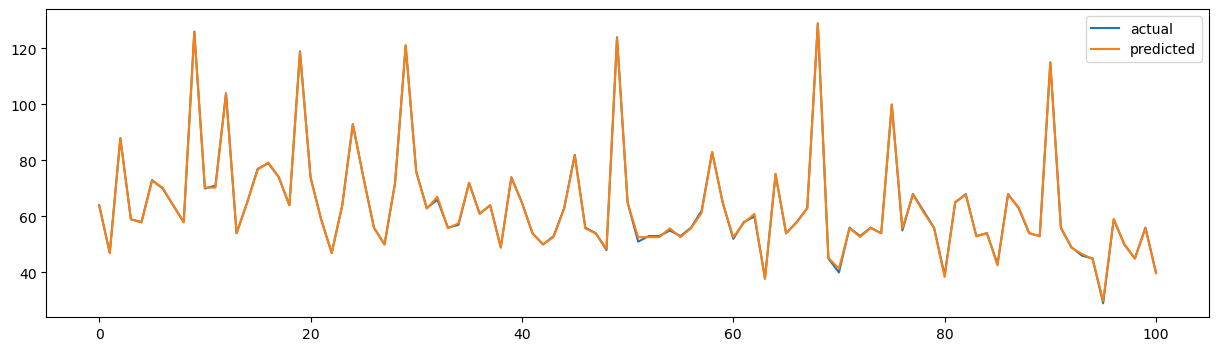

In [102]:
train_lgb = lgb.Dataset(train_X,y_train)
valid_lgb = lgb.Dataset(test_X,y_test)
    
model = lgb.train(
    params,
    train_lgb,
    valid_sets=valid_lgb,
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=1)
        ]
    )

pred = model.predict(train_X)

p = pd.DataFrame({"actual":y_train,"predicted":pred})
p.plot(figsize=(15,4))
print("RMSE",mean_squared_error(y_train,pred)**0.5)




In [103]:
train_lgb = lgb.Dataset(train_X,y_train)
valid_lgb = lgb.Dataset(test_X,y_test)
    
model = lgb.train(
    params,
    train_lgb,
    valid_sets=valid_lgb,
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
         lgb.log_evaluation(period=1)
        ]
    )

pred = model.predict(test_X)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73
[LightGBM] [Info] Number of data points in the train set: 101, number of used features: 8
[LightGBM] [Info] Start training from score 63.950495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 61.0888
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l1: 58.7521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l1: 56.6491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l1: 54.7564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l1: 52.8141
[LightGBM] [Warning] No further

In [104]:
def objective(trial):
    params = {
        'objective':'regression',
        'metric':'mae',
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True)
    }
    
    trians = []
    tests = []
    
    tscv = TimeSeriesSplit(n_splits=5)
    tr = dat[dat["t"]==1][cols]
    for train_index, test_index in tscv.split(tr):
       tr.loc[train_index,"tt"] = int(1)
       tr.loc[test_index,"tt"] = int(0)
       #tr["tt"] = tr["tt"].astype(int)
       tmp = pd.get_dummies(tr)
    
       trainX = tmp[tmp["tt"]==1]
       del trainX["tt"]
       testX = tmp[tmp["tt"]==0]
       del testX["tt"]
       y_train = tmp[tmp["tt"]==1]["y"]
       y_test = tmp[tmp["tt"]==0]["y"]
    
       train_lgb = lgb.Dataset(trainX,y_train)
       valid_lgb = lgb.Dataset(testX,y_test)
    
       model = lgb.train(
           params,
           train_lgb,
           valid_sets=valid_lgb,
           num_boost_round=1000,
           callbacks=[lgb.early_stopping(stopping_rounds=100)]
           )
    
       pred_train = model.predict(trainX)
       pred_test = model.predict(testX)
       
       print("TRAIN:",mean_squared_error(y_train,pred_train)**0.5, "VARIDATE",mean_absolute_error(y_test, pred_test)**0.5)
       trains.append(mean_squared_error(y_train,pred_train)**0.5)
       tests.append(mean_squared_error(y_test, pred_test)**0.5)
    return np.mean(tests)

In [105]:
# optunaによるパラメータ調整
#study = optuna.create_study(
#    direction="minimize",
#    sampler=optuna.samplers.TPESampler(seed=42)
#)
#study.optimize(objective,n_trials=100,show_progress_bar=True)

In [106]:
#print(study.best_params)

In [107]:
best_params = study.best_params
best_params.update({
    "objective":"regression",
    "metric":"mae"
})

cols = ["precipitation","weather","days","curry","fun","y","t"]
tmp = pd.get_dummies(dat[cols])
train_X = tmp[tmp["t"]==1]
del train_X["t"]
test_X = tmp[tmp["t"]==0]
del test_X["t"]
y_train = tmp[tmp["t"]==1]["y"]
y_test = tmp[tmp["t"]==0]["y"]

train_lgb = lgb.Dataset(train_X,y_train)
valid_lgb = lgb.Dataset(test_X,y_test)
    
model = lgb.train(
    best_params,
    train_lgb,
    valid_sets=valid_lgb,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )

pred = model.predict(test_X)
plt.plot(pred)

NameError: name 'study' is not defined